<a href="https://colab.research.google.com/github/yucong-guo/cs224/blob/main/cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn

In [22]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

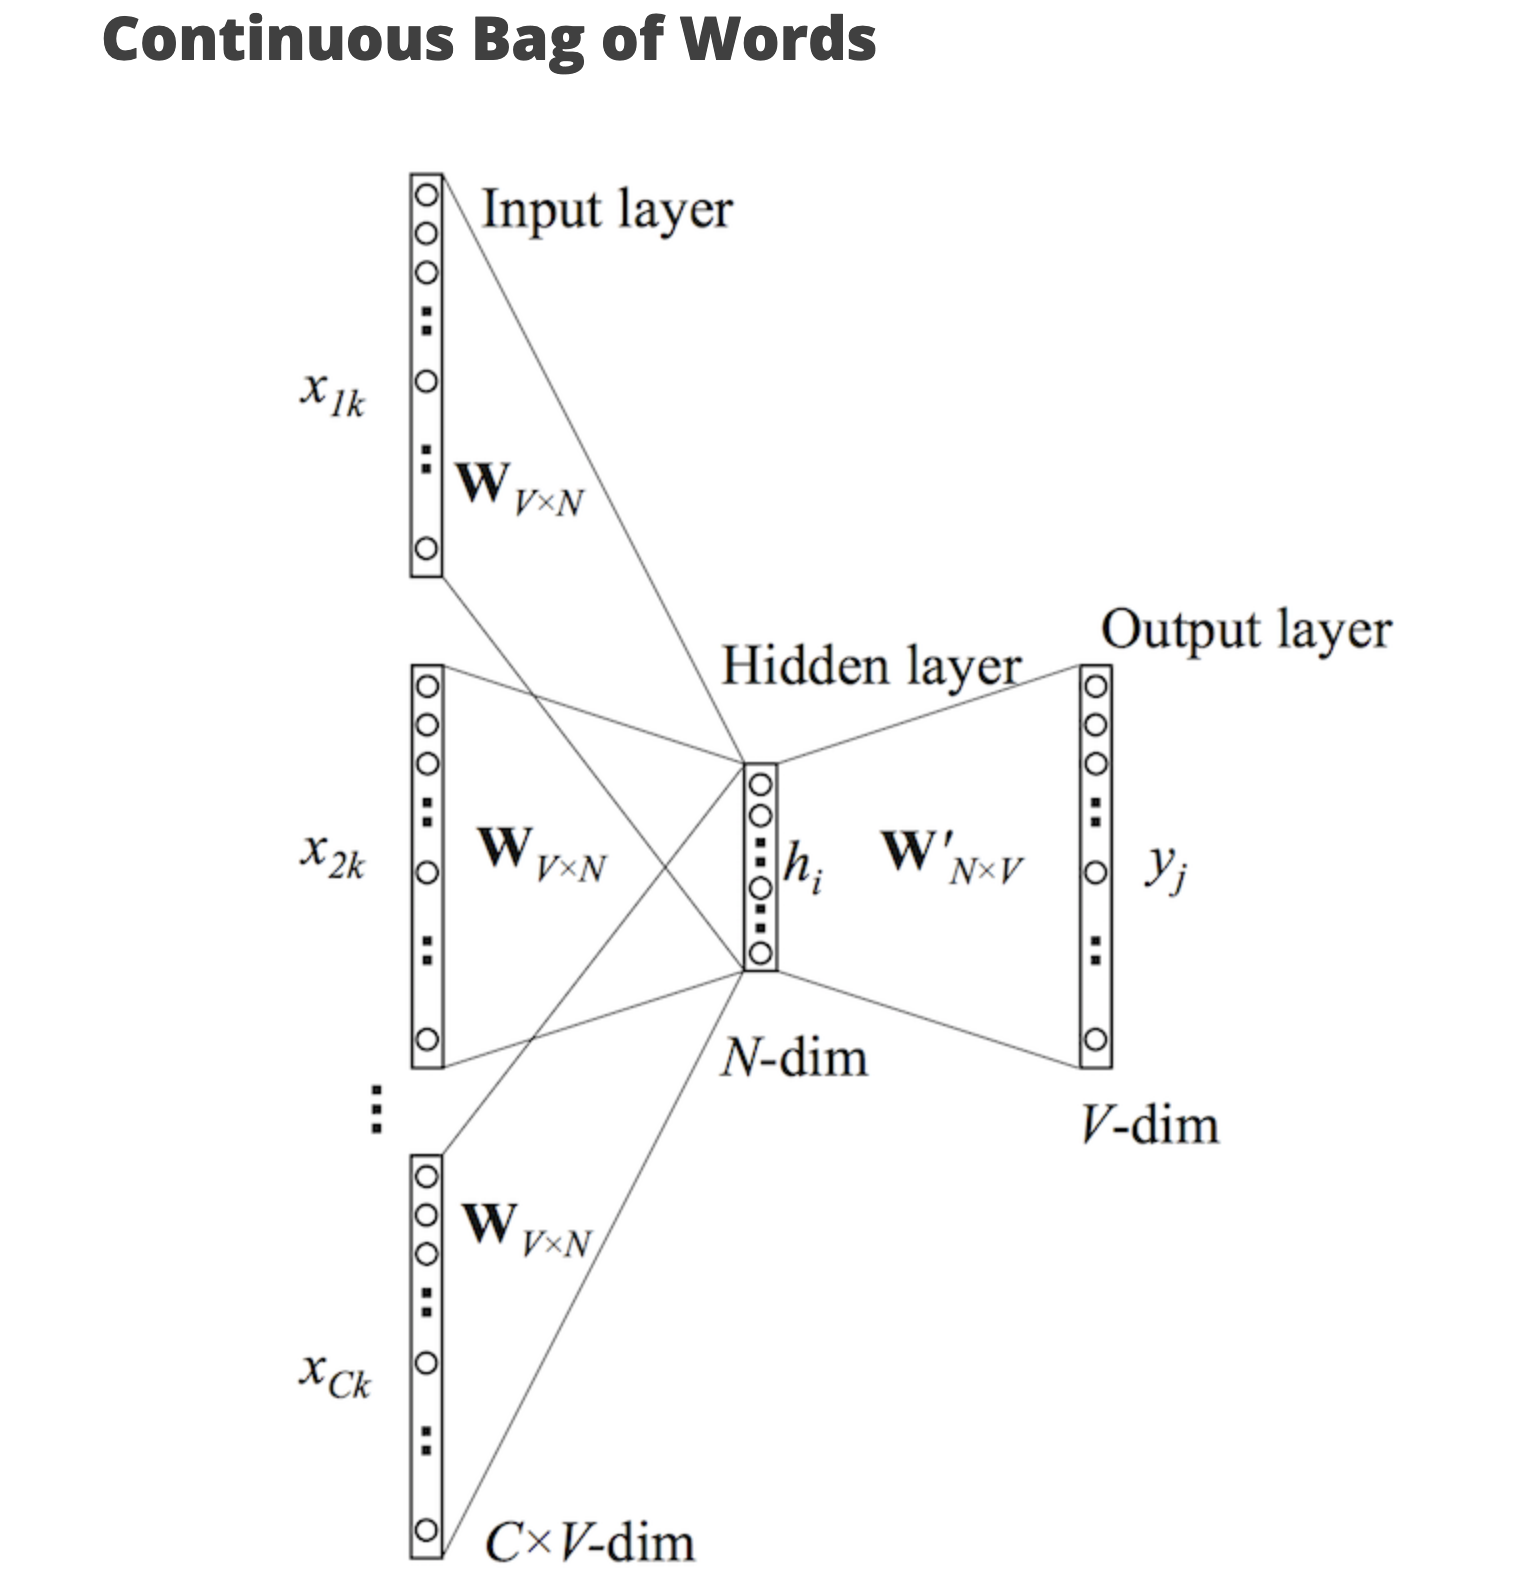

In [54]:
from IPython.display import Image, display
display(Image('/content/Screenshot 2024-02-29 at 1.58.54 AM.png'))

In [25]:
# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
data[:3]

[(['We', 'are', 'to', 'study'], 'about'),
 (['are', 'about', 'study', 'the'], 'to'),
 (['about', 'to', 'the', 'idea'], 'study')]

In [26]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [31]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

In [51]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)


    def forward(self, inputs):
        '''
        inputs: (4,)
        '''
        emb = self.embeddings(inputs) #(4, embedding_dim)
        emb_sum = sum(self.embeddings(inputs)) #(embedding_dim, )
        embeds = emb_sum.view(1,-1) #(1,embedding_dim)
        out = self.linear1(embeds) #(1, 128)
        out = self.activation_function1(out) #(1, 128)
        out = self.linear2(out) #(1, vocab_size)
        out = self.activation_function2(out) #(1, vocab_size)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [52]:
model = CBOW(vocab_size, EMDEDDING_DIM)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#TRAINING
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

In [34]:
make_context_vector(data[0][0], word_to_ix)

tensor([19, 16, 27, 26])

In [53]:
#TESTING
context = ['People','create','to', 'direct']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

#Print result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['People', 'create', 'to', 'direct']

Prediction: programs
